In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import sqlite3
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Load the true positive predictions from the CSV file
conn = sqlite3.connect('../../../../data/nfp2/nfp2_combined.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators_combined"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

# Extract features and target variable
X = data_df[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = data_df['convergence']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

import lightgbm as lgb

best_params = {
    "boosting_type": "gbdt",
    "max_depth": 29,
    "num_leaves": 483,
    'n_estimators': 818,
    "subsample_for_bin": 98338,
    'min_split_gain': 0.09767211400638387,
    "learning_rate": 0.12909794654157747,
    'min_child_samples': 143
}

# Create and train the LightGBM model with the manually defined best parameters
best_gbm = lgb.LGBMClassifier(**best_params)
best_gbm.fit(X_train, Y_train)

Data loaded successfully
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Number of positive: 365988, number of negative: 9570815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 9936803, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036832 -> initscore=-3.263873
[LightGBM] [Info] Start training from score -3.263873


LGBMClassifier(learning_rate=0.12909794654157747, max_depth=29,
               min_child_samples=143, min_split_gain=0.09767211400638387,
               n_estimators=818, num_leaves=483, subsample_for_bin=98338)

In [2]:
# Predict on the test set
preds = best_gbm.predict(X_test)

done


In [3]:
accuracy = accuracy_score(Y_test, preds)
precision = precision_score(Y_test, preds)
recall = recall_score(Y_test, preds)
f1 = f1_score(Y_test, preds)
roc_auc = roc_auc_score(Y_test, preds)
conf_matrix = confusion_matrix(Y_test, preds, normalize = 'true')

Evaluation Metrics:
Accuracy: 0.9917655616433614
Precision: 0.9209166745663097
Recall: 0.8493770491803279
F1 Score: 0.8837013621995315
ROC AUC Score: 0.9232938664193352
Confusion Matrix:
[[0.99721068 0.00278932]
 [0.15062295 0.84937705]]


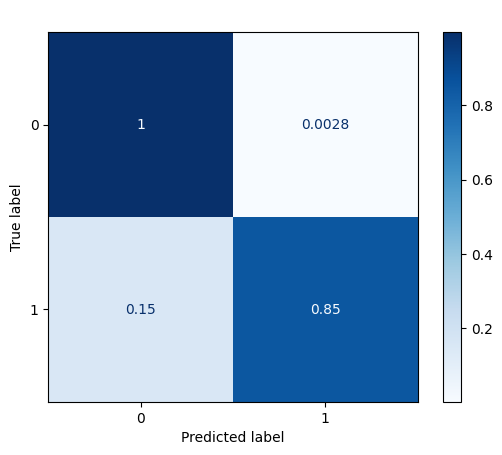

Feature Importance:
rbc_1_1: 63562
zbs_1_1: 63426
zbs_m1_1: 63302
rbc_m1_1: 62953
zbs_0_1: 49546
rbc_0_1: 49370
rbc_1_0: 21478
zbs_1_0: 20639


In [4]:
import matplotlib.pyplot as plt

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_gbm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('  ')
plt.savefig('confusion_matrixpdf.pdf')  
plt.show()

feature_importance = best_gbm.feature_importances_

feature_importance_dict = dict(zip(X_train.columns, feature_importance))

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


In [5]:
from sklearn.metrics import classification_report

class_report = classification_report(Y_test, preds, digits=2)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2392701
           1       0.92      0.85      0.88     91500

    accuracy                           0.99   2484201
   macro avg       0.96      0.92      0.94   2484201
weighted avg       0.99      0.99      0.99   2484201



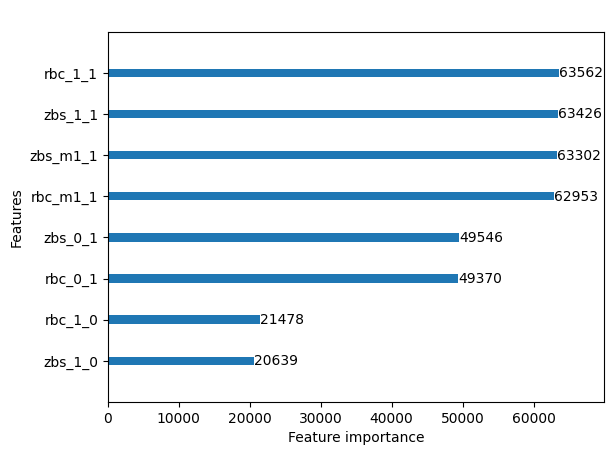

In [6]:
lgb.plot_importance(best_gbm, max_num_features=8, title = '  ', grid= False, importance_type= 'split')
plt.savefig('feature_importance.pdf') 